# Air Pollution Forecasting using Recurrent Neural Networks

In this tutorial, you will predict the Air Pollution by using RNN. We will use the dataset **Beijing PM2.5 Data** from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data). This is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.

We will use [Keras](https://keras.io/), a high-level API for deep learning, which is a wrapper of TensorFlow, CNTK, or Theano. Keras was developed with a focus on enabling fast experimentation, which makes this framework easy to use and learn deep learning.

__All the libraries used in this tutorial are <font color='red'>Open Source</font>__.

PS: this tutorial is inspired on [Machine Learning Mastery](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/) but with many modifications.

In [2]:
# Standard libraries - no deep learning yet
import numpy as np # written in C, is faster and robust library for numerical and matrix operations
import pandas as pd # data manipulation library, it is widely used for data analysis and relies on numpy library.
import matplotlib.pyplot as plt # for plotting
from datetime import datetime # supplies classes for manipulating dates and times in both simple and complex ways

from utils import *

# the following to lines will tell to the python kernel to alway update the kernel for every utils.py
# modification, without the need of restarting the kernel.
# Of course, for every motification in util.py, we need to reload this cell
%load_ext autoreload
%autoreload 2

# If you see some RuntimeWarning, just ignore them.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Processing

The **Beijing PM2.5 Data** includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain. The complete feature list in the data is as follows:

 - **No**: row number
 - **year**: year of data in this row
 - **month**: month of data in this row
 - **day**: day of data in this row
 - **hour**: hour of data in this row
 - **pm2.5**: PM2.5 concentration
 - **DEWP**: Dew Point
 - **TEMP**: Temperature
 - **PRES**: Pressure
 - **cbwd**: Combined wind direction
 - **Iws**: Cumulated wind speed
 - **Is**: Cumulated hours of snow
 - **Ir**: Cumulated hours of rain
 
 
We need to consolidate the _date-time_ information into a _single date-time_ to make it feasible to be used as an index in [Pandas](https://pandas.pydata.org/) library. To do so, we will use the function **parse_datetime** as a parser (see _utils.py_) and will passed throught the function  [read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html). Node that **parse_datatime** is a value to be used in _date_\__parser_ parameter by **read_csv**.

In [4]:
dataset = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv',  
                      parse_dates = [['year', 'month', 'day', 'hour']], # parse these dates
                      index_col=0, # change the index col 0
                      date_parser=parse_datetime)

# summarize first 25 rows
dataset.head(25)

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0
2010-01-01 05:00:00,6,NaN,-19,-10.0,1017.0,NW,16.10,0,0
2010-01-01 06:00:00,7,NaN,-19,-9.0,1017.0,NW,19.23,0,0
2010-01-01 07:00:00,8,NaN,-19,-9.0,1017.0,NW,21.02,0,0
2010-01-01 08:00:00,9,NaN,-19,-9.0,1017.0,NW,24.15,0,0


Note that, some **air pollution** (pm2.5) have NaN value. In order to fix this, we will change every NaN to 0 by using the function [fillna](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html).

The main difference between [dropna](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html) and [fillna](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html), is that the first one remove the NaN value and the second one changes the value.

Besides that, we need to remove the column **No** (number), as it is not required in our analysis, we will use the function [drop](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html) for this task.

In [5]:
dataset.drop('No', axis=1, inplace=True)
# Manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
# Set the index name to 'date'
dataset.index.name = 'date'

# Change the values in 'pollution' of all NaNs to 0
dataset['pollution'].fillna(0, inplace=True)

# By inspecting the data, we realised that the first 24 hours where NaN, 
# so lets remove the rows related to this NaN (even after changing them to 0). We don't remove
# the other columns with NaN because we don't exacly where they are. We can try to 
# find them and remove them, but let's keep them.
dataset = dataset[24:]

# Print first 25 rows
dataset.head(25)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
2010-01-02 05:00:00,109.0,-7,-6.0,1022.0,SE,7.14,3,0
2010-01-02 06:00:00,105.0,-7,-6.0,1023.0,SE,8.93,4,0
2010-01-02 07:00:00,124.0,-7,-5.0,1024.0,SE,10.72,0,0
2010-01-02 08:00:00,120.0,-8,-6.0,1024.0,SE,12.51,0,0


In [6]:
# Visualising other NaNs that were change to 0 
# After some inspection we found other ones (have a lot more in the dataset, feel free to check them) 
# let's do a sanity check to see if they were changed to 0 by fillna function
dataset[3500:3505]

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-05-27 20:00:00,0.0,16,18.0,1015.0,NE,2.68,0,9
2010-05-27 21:00:00,0.0,16,18.0,1015.0,NW,1.79,0,10
2010-05-27 22:00:00,0.0,16,18.0,1015.0,cv,0.89,0,11
2010-05-27 23:00:00,0.0,16,18.0,1014.0,cv,1.78,0,12
2010-05-28 00:00:00,90.0,16,17.0,1014.0,NE,0.89,0,13


### Visualising the Features

Here we will plot each series as a separate subplot, except wind speed direction, which is categorical.

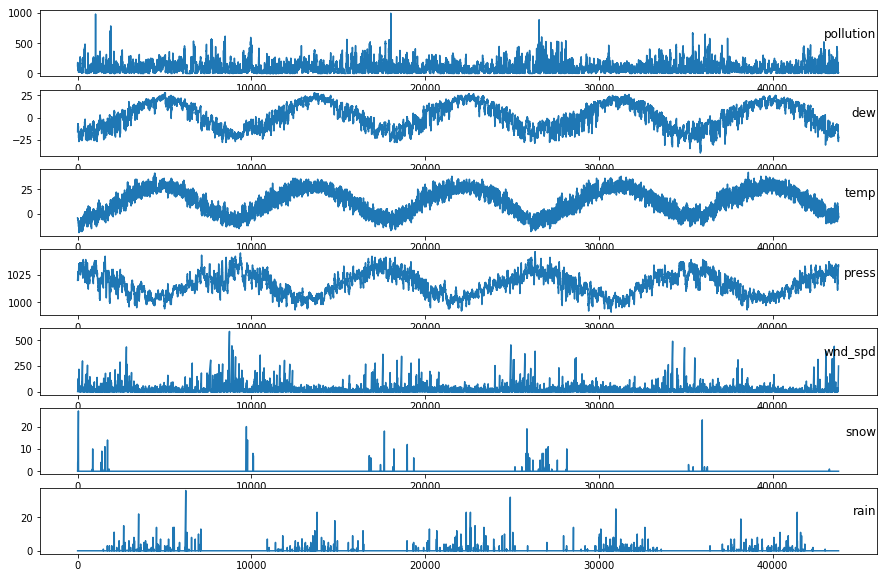

In [7]:
values = dataset.values
# Specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1

# Plot each column
plt.figure(figsize=(15, 10))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1

plt.show()

### Creating the Windowed Data Set

This step will involve framing the dataset as a **supervised learning problem**. As we would like to predict the air pollution, we will set the corresponding column to be the output (label $y$) (see the function **create_window** in _utils.py_ to better understand how this function works).

We would like to predict the air pollution ($y_t$) at the current hour ($t$) given the pollution measurement and weather conditions at the prior time steps (lets say $t-1, t-2, \dots t-n$, in which $n$ is the number of past observations to be used to forcast $y_t$).

The function **create_window** (see _utils.py_) converts the time-series to a supervised learning problem. In this function, the new dataset is constructed as a **DataFrame**, with each column suitably named both by variable number and time step, for example, $var1(t-1)$ for the air pollution at the previous observation ($t-1$). This allows you to design a variety of different time step sequence type forecasting problems from a given univariate or multivariate time series.

In [8]:
# Performing the sliding window with number of past observation (n_in) equal one and future observations 
# (n_out) equal 1, with drop_nan = False.
t = create_window(dataset.values, n_in = 1, n_out = 1)

# Print the first rows
t.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129,-16,-4,1020,SE,1.79,0,0
1,129,-16,-4,1020,SE,1.79,0,0,148,-15,-4,1020,SE,2.68,0,0
2,148,-15,-4,1020,SE,2.68,0,0,159,-11,-5,1021,SE,3.57,0,0
3,159,-11,-5,1021,SE,3.57,0,0,181,-7,-5,1022,SE,5.36,1,0
4,181,-7,-5,1022,SE,5.36,1,0,138,-7,-5,1022,SE,6.25,2,0


As you can see in the table above, some NaN where included in the dataset, in order to remove these value we will set _drop_nan_ = True. This will allow us to use pandas function [dropna](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html)

In [9]:
# Performing the sliding window with number of past observation (n_in) equal one and future observations 
# (n_out) equal 1, with drop_nan = False.
t = create_window(dataset.values, n_in = 1, n_out = 1, drop_nan = True)

# Print the first rows
t.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,129,-16,-4,1020,SE,1.79,0,0,148,-15,-4,1020,SE,2.68,0,0
2,148,-15,-4,1020,SE,2.68,0,0,159,-11,-5,1021,SE,3.57,0,0
3,159,-11,-5,1021,SE,3.57,0,0,181,-7,-5,1022,SE,5.36,1,0
4,181,-7,-5,1022,SE,5.36,1,0,138,-7,-5,1022,SE,6.25,2,0
5,138,-7,-5,1022,SE,6.25,2,0,109,-7,-6,1022,SE,7.14,3,0


### Data Preparation

Here we will change wind direction to a **one-hot encoded** representation, normalise all the features and transform the data into a supervised learning problem. The weather variables for the hour to be predicted ($t$) are then removed, as we would like to predict just the air pollution (first element in every feature array).


For this task, we will use the library [Scikit-learn](http://scikit-learn.org/stable/), which is a very powerful machine learning library for Python.

In [10]:
# Scikit learn libraries
from sklearn.preprocessing import MinMaxScaler # Allows normalisation
from sklearn.preprocessing import LabelEncoder # Encode labels with value between 0 and n_classes-1.

In order to do the data preparation, we will use:
 - [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) encode categorical integer features to one-hot encoding
 - [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to normalise the dataset on the (0,1) interval
 
**One hot encoding** is a process to categorical variables (in our case wind direction) into a form that could be provided to ML algorithms to do a better job in prediction. In our case, we would like to convert the wind direction (categorical) to a integer representation.

In [13]:
# Get the numpy array from the DataFrame
values = dataset.values

# print some wind direction
print('Before one-hot representation')
print(values[41:47, ])

# Create the one-hot representation for wind direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# print the wind direction
print('\nAfter one-hot representation')
print(values[41:47, ])

Before one-hot representation
[[70.0 -11 -9.0 1020.0 'SE' 127.84 23 0]
 [61.0 -11 -9.0 1021.0 'cv' 0.89 24 0]
 [53.0 -11 -9.0 1022.0 'cv' 1.78 25 0]
 [71.0 -10 -9.0 1022.0 'NW' 4.02 26 0]
 [72.0 -11 -10.0 1023.0 'NW' 7.15 27 0]
 [76.0 -11 -9.0 1023.0 'NW' 11.17 0 0]]

After one-hot representation
[[70.0 -11 -9.0 1020.0 2 127.84 23 0]
 [61.0 -11 -9.0 1021.0 3 0.89 24 0]
 [53.0 -11 -9.0 1022.0 3 1.78 25 0]
 [71.0 -10 -9.0 1022.0 1 4.02 26 0]
 [72.0 -11 -10.0 1023.0 1 7.15 27 0]
 [76.0 -11 -9.0 1023.0 1 11.17 0 0]]


In [14]:
# Convert the data to float
values = values.astype('float32')

# Normalise features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Transform the time-series to a supervised learning problem representation
reframed = create_window(scaled, n_in = 1, n_out = 1, drop_nan = True)

# Summarise the new frames without removing the wheather data
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0


Note that we have 8 outputs (**var1(t)** to **var2(t)**). As we would like to predict the air pollution, we need to remove the wheather features. To do so, we will use the function [drop](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html).

In [15]:
# Remove the columns we don't want to predict, i.e., keep just the air pollution
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


Note that **var1(t)** represents the output ($y_t$), which is the air pollution.

## Building the Models

So far, we just created the dataset and showed how we can use pandas for data manipulation. Now, we will preprocess the data and build the following models:
 
 - Simple_RNN
 - GRU
 - LSTM

For [Keras](https://keras.io/), we will using [Tensorflow](https://www.tensorflow.org/) backend by default

In [16]:
# Loading the libraries required for this step.
# keras components, we will describe each one along this tutorial, so don't be worry 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional

from math import sqrt

from sklearn.metrics import mean_squared_error # allows compute the mean square error to performance analysis

Using TensorFlow backend.


### Splitting the Data into Train and Test Sets

First, we need to split the dataset into train and test sets.

In [17]:
# We will use 80% of the data for training and 20% for testing
train_size = 0.8

values = reframed.values
n_train_hours = round(train_size * dataset.shape[0])
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35040, 1, 8) (35040,) (8759, 1, 8) (8759,)


### Simple (Basic) RNN

Our first model is based on a simple (basic) RNN. This model will consist in a **many_to_one** architecture, in which the input is the **sequence** of the past observations and the output is the predicted value (dimension 1). The Figure below illustrates how the model will look like, note that each _RNN Cell_ is as described in the lecture, so we will have _n_in_ (number of past observations) cells in the model.

![rnn_type](imgs/air_pollution_rnn.png)

For this model, we will use just one RNN cell as we are using just one past observation ($t-1$), and the output is one dimension (air pollution). To predict the output, we will use a fully-connected layer (represented by the block FC in the figure) with a linear activation function. In practice, deep learning frameworks such as Tensorflow and Keras requires the definition of a fully-connected layer for the output.

To build the model, we will use the following components from Keras:

 - [Sequencial](https://keras.io/models/sequential/): allows us to create models layer-by-layer. 
 - [SimpleRNN](https://keras.io/layers/recurrent/): provides a Basic (simple) RNN architecture
 - [Dense](https://keras.io/layers/core/): provides a regular fully-connected layer
 - [Activation](https://keras.io/activations/): defines the activation function to be used

Basically, we will define the sequence of our model by using _Sequential()_, include the layers:

```
    model = Sequential()
    model.add(SimpleRNN(...))
    ...
```
and, once created the model, we will configure it for training by using the built-in method [compile](https://keras.io/models/model/), in which we will define the [loss](https://keras.io/losses/) function (mean squared error, mean absolute error, cosine proximity, among others.) and the [optimizer](https://keras.io/optimizers/) (Stochastic gradient descent, RMSprop, adam, among others), as follows:

```
    model.compile(loss = "...", 
                  optimizer = "...")
```

Also, we have the option to see a summary representation of our model by using the function [summary](https://keras.io/models/about-keras-models/#about-keras-models).

In [18]:
# Define the model.
model_rnn = Sequential()

# The input shape is (1,8), as we are using multivariate dataset (8 features).
# The activation function for each cell, by default, is 'tanh' (activation='tanh').
# As we are using many-to-one architecture, wee need to set the parameter return_sequences to False 
# (by default is True). This parameter is quite important because this determines whether to return 
# the last output in the output sequence,  or the full sequence (e.g. for many-to-many architecture 
# we set return_sequences=True).  As we are using a many_to_one architecture, we are interested 
# in the last output. 

# Besides that, we need to set the number of hidden unit in the cell, which can be done by setting the
# parameter units. Note that the output of the cell is the same shape of the units, for instance, if units
# is equal 4, we will have an output array with four elements that represent the weights to be used
# by the fully-connect (dense) layer, this last layer predicts output (y_hat).
model_rnn.add(SimpleRNN(input_shape=(train_X.shape[1], train_X.shape[2]), 
                        units = 32, # try here with 4 or 10 units and check the performance of the model
                        return_sequences = False))
model_rnn.add(Dense(units=1)) # in which units is the dimension of the output space, our case 1 (y_hat)
                              # By default, the activation function of the fully-connect layer is linear

# We compile the model by defining the mean absolute error (denoted by mae) as loss function and
# adam as optimizer
model_rnn.compile(loss = "mae", 
                  optimizer = "adam")

# just print the model
model_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1312      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________


Observe that the output of the simple_rnn_1 layer (LSTM) is 32, which means we will have an array with 32 elementrs representing the weights. 

Once defined the model, we can train it by using the function [fit](https://keras.io/models/model/). This will train the model by using the defined optimiser (Adam in our case) for a given number of epochs. Also we need to define other parameters such as:

 - batch size
 - epochs
 - validation split, which define the percentage of training data to be using for validation (not mandatory)
 - among others (click [here](https://keras.io/models/model/) for more information)
 
This function return the _history_ of the training, that can be used for further performance analysis.

In [19]:
# Training
hist_rnn = model_rnn.fit(train_X, train_y, 
                        epochs=30, 
                        batch_size=72, 
                        validation_split = 0.1,
                        verbose=0, shuffle=False) # To visualise the output, set verbose=1

#### Using the history 

Here we can see if the model overfits or underfits

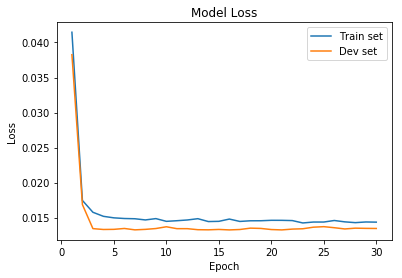

In [20]:
plot_loss(hist_rnn)

#### Prediction and Performance Analysis

Once the model was trained, we can use the function [predict](https://keras.io/models/model/) to do some predictions, by doing so, we can forecast for the entire test dataset.

We combine the predicted pollution with the test dataset and invert the scaling (transform the values to the original ones). We also invert scaling on the test dataset with the expected pollution. To do so, we use the function **inverse_transform** (see _utils.py_)

Given the predictions and expected values in their original scale, we can then compute the error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE).

In [21]:
yhat_rnn = model_rnn.predict(test_X)

# performing the inverse transform on test_X and yhat_rnn
inv_y_rnn, inv_yhat_rnn = inverse_transform(test_X, test_y, yhat_rnn, scaler)

# calculate RMSE
rmse_rnn = np.sqrt(mean_squared_error(inv_y_rnn, inv_yhat_rnn))
print('Test RMSE: %.3f' % rmse_rnn)

Test RMSE: 24.494


### Visualising the predicted Data

Here, we plot the test data against the the predicted data.

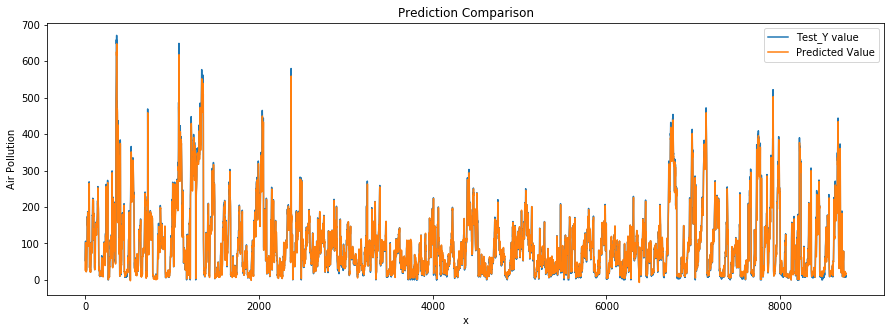

In [22]:
plot_comparison([inv_y_rnn, inv_yhat_rnn], 
                ['Test_Y value','Predicted Value'], 
                title='Prediction Comparison')

Let see closer to see how the prediction looks like

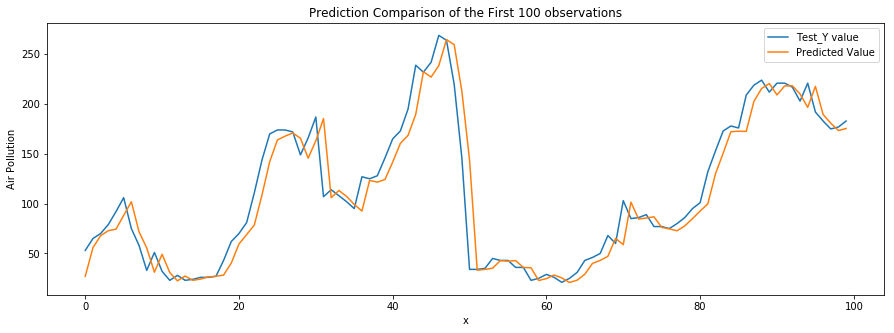

In [25]:
plot_comparison([inv_y_rnn[0:100], inv_yhat_rnn[0:100]], 
                ['Test_Y value', 'Predicted Value'], 
                title='Prediction Comparison of the First 100 observations')

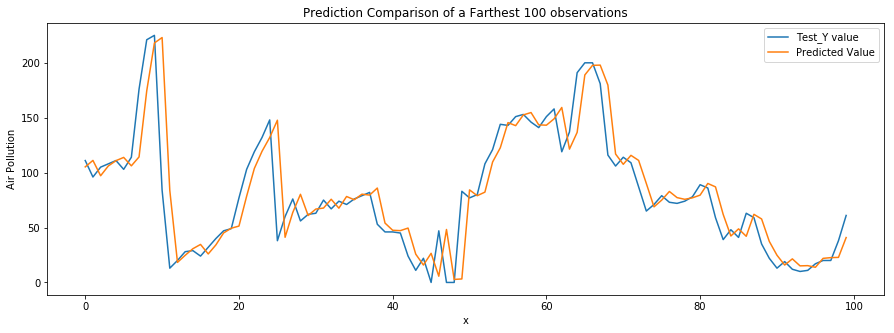

In [26]:
plot_comparison([inv_y_rnn[4000:4100], inv_yhat_rnn[4000:4100]], 
                ['Test_Y value', 'Predicted Value'], 
                title='Prediction Comparison of a Farthest 100 observations')

Not too bad, lets see if we can improve it by using other models.

### GRU

Our second model is based on a GRU. This model will consist in a **many_to_one** architecture, in which the input is the **sequence** of the past observations and the output is the predicted value (dimension 1). The Figure below illustrates how the model will look like, note that each _GRU Cell_ is as described in the lecture, so we will have _n_in_ (number of past observations) cells in the model.

![rnn_type](imgs/air_pollution_gru.png)

For this model, we will use just one GRU cell as we are using just one past observation ($t-1$), and the output is one dimension (air pollution). To predict the output, we will use a fully-connected layer (represented by the block FC in the figure) with a linear activation function. In practice, deep learning frameworks such as Tensorflow and Keras requires the definition of a fully-connected layer for the output.

To build the model, we will use the following components from Keras:

 - [Sequencial](https://keras.io/models/sequential/): allows us to create models layer-by-layer. 
 - [GRU](https://keras.io/layers/recurrent/): provides a GRU architecture
 - [Dense](https://keras.io/layers/core/): provides a regular fully-connected layer
 - [Activation](https://keras.io/activations/): defines the activation function to be used

Basically, we will define the sequence of our model by using _Sequential()_, include the layers:

```
    model = Sequential()
    model.add(GRU(...))
    ...
```
and, once created the model, we will configure it for training by using the built-in method [compile](https://keras.io/models/model/), in which we will define the [loss](https://keras.io/losses/) function (mean squared error, mean absolute error, cosine proximity, among others.) and the [optimizer](https://keras.io/optimizers/) (Stochastic gradient descent, RMSprop, adam, among others), as follows:

```
    model.compile(loss = "...", 
                  optimizer = "...")
```

Also, we have the option to see a summary representation of our model by using the function [summary](https://keras.io/models/about-keras-models/#about-keras-models).

In [27]:
# Define the model.
model_gru = Sequential()

# Here we are using the same approach applied for in the RNN step
model_gru.add(GRU(input_shape=(train_X.shape[1], train_X.shape[2]), 
                        units = 32, # try here with 4 or 10 units and check the performance of the model
                        return_sequences = False))
model_gru.add(Dense(units=1)) 

model_gru.compile(loss = "mae", 
                  optimizer = "adam")

# just print the model
model_gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                3936      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________


See RNN model comments to fit the model

In [28]:
# Training
hist_gru = model_gru.fit(train_X, train_y, 
                        epochs=30, 
                        batch_size=72, 
                        validation_split = 0.1,
                        verbose=0, # To visualise the output, set verbose=1 
                        shuffle=False) 

#### Using the history 

Here we can see if the model overfits or underfits

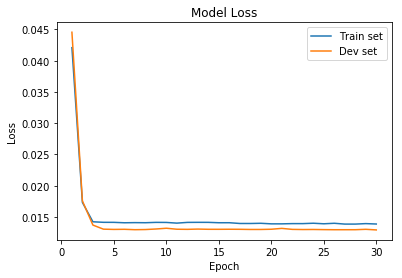

In [29]:
plot_loss(hist_gru)

#### Prediction and Performance Analysis

See RNN model comments to perform this task

In [30]:
yhat_gru = model_gru.predict(test_X)

# performing the inverse transform on test_X and yhat_rnn
inv_y_gru, inv_yhat_gru = inverse_transform(test_X, test_y, yhat_gru, scaler)

# calculate RMSE
rmse_gru = np.sqrt(mean_squared_error(inv_y_gru, inv_yhat_gru))
print('Test RMSE: %.3f' % rmse_gru)

Test RMSE: 24.253


### Visualising the predicted Data

Here, we plot the test data against the the predicted data.

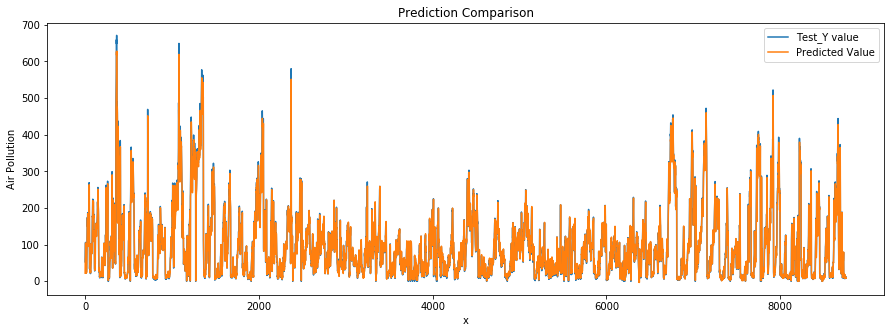

In [31]:
plot_comparison([inv_y_gru, inv_yhat_gru], 
                ['Test_Y value','Predicted Value'], 
                title='Prediction Comparison')

Let see closer to see how the prediction looks like

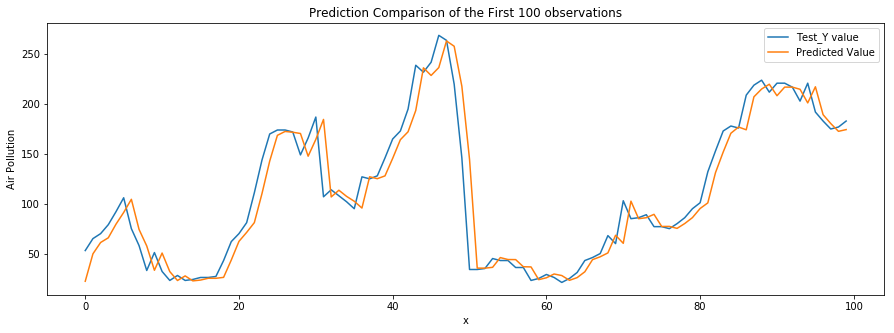

In [32]:
plot_comparison([inv_y_gru[0:100], inv_yhat_gru[0:100]], 
                ['Test_Y value', 'Predicted Value'], 
                title='Prediction Comparison of the First 100 observations')

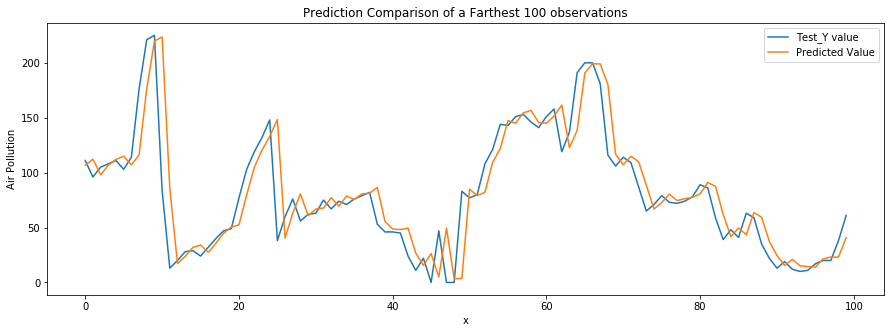

In [33]:
plot_comparison([inv_y_gru[4000:4100], inv_yhat_gru[4000:4100]], 
                ['Test_Y value','Predicted Value'], 
                title='Prediction Comparison of a Farthest 100 observations')

### LSTM

Our third model is based on a LSTM. This model will consist in a **many_to_one** architecture, in which the input is the **sequence** of the past observations and the output is the predicted value (dimension 1). The Figure below illustrates how the model will look like, note that each _LSTM Cell_ is as described in the lecture, so we will have _n_in_ (number of past observations) cells in the model.

![rnn_type](imgs/air_pollution_lstm.png)

For this model, we will use just one LSTM cell as we are using just one past observation ($t-1$), and the output is one dimension (air pollution). To predict the output, we will use a fully-connected layer (represented by the block FC in the figure) with a linear activation function. In practice, deep learning frameworks such as Tensorflow and Keras requires the definition of a fully-connected layer for the output.
To build the model, we will use the following components from Keras:

 - [Sequencial](https://keras.io/models/sequential/): allows us to create models layer-by-layer. 
 - [LSTM](https://keras.io/layers/recurrent/): provides a LSTM architecture
 - [Dense](https://keras.io/layers/core/): provides a regular fully-connected layer
 - [Activation](https://keras.io/activations/): defines the activation function to be used

Basically, we will define the sequence of our model by using _Sequential()_, include the layers:

```
    model = Sequential()
    model.add(LSTM(...))
    ...
```
and, once created the model, we will configure it for training by using the built-in method [compile](https://keras.io/models/model/), in which we will define the [loss](https://keras.io/losses/) function (mean squared error, mean absolute error, cosine proximity, among others.) and the [optimizer](https://keras.io/optimizers/) (Stochastic gradient descent, RMSprop, adam, among others), as follows:

```
    model.compile(loss = "...", 
                  optimizer = "...")
```

Also, we have the option to see a summary representation of our model by using the function [summary](https://keras.io/models/about-keras-models/#about-keras-models).

In [34]:
# Define the model.
model_lstm = Sequential()

# Here we are using the same approach applied for in the RNN step
model_lstm.add(LSTM(input_shape=(train_X.shape[1], train_X.shape[2]), 
                        units = 32, # try here with 4 or 10 units and check the performance of the model
                        return_sequences = False))
model_lstm.add(Dense(units=1)) 

model_lstm.compile(loss = "mae", 
                  optimizer = "adam")

# just print the model
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5248      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


See RNN model comments to perform this task

In [35]:
# fit network
hist_lstm = model_lstm.fit(train_X, train_y, 
                        epochs=30, 
                        batch_size=72, 
                        validation_split = 0.1,
                        verbose=0, # To visualise the output, set verbose=1 
                        shuffle=False) 

#### Using the history 

Here we can see if the model overfits or underfits

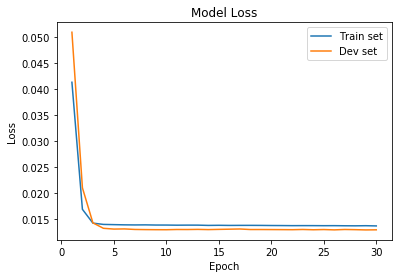

In [36]:
plot_loss(hist_lstm)

#### Prediction and Performance Analysis

See RNN model comments to perform this task

In [37]:
yhat_lstm = model_lstm.predict(test_X)

# performing the inverse transform on test_X and yhat_rnn
inv_y_lstm, inv_yhat_lstm = inverse_transform(test_X, test_y, yhat_lstm, scaler)

# calculate RMSE
rmse_lstm = np.sqrt(mean_squared_error(inv_y_lstm, inv_yhat_lstm))
print('Test RMSE: %.3f' % rmse_gru)

Test RMSE: 24.253


### Visualising the predicted Data

Here, we plot the test data against the the predicted data.

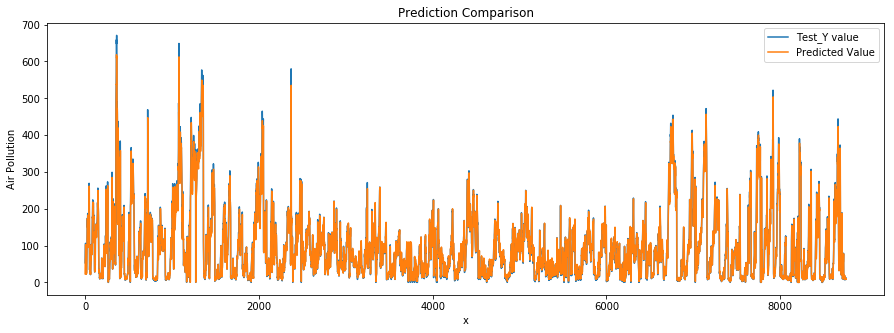

In [38]:
plot_comparison([inv_y_lstm, inv_yhat_lstm], 
                ['Test_Y value','Predicted Value'], 
                title='Prediction Comparison')

Let see closer to see how the prediction looks like

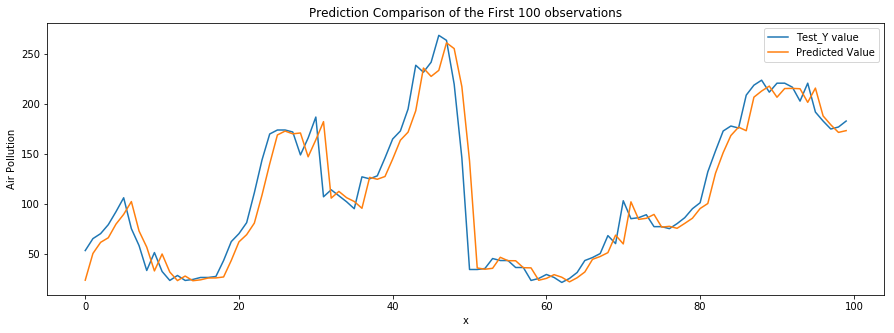

In [39]:
plot_comparison([inv_y_lstm[0:100], inv_yhat_lstm[0:100]], 
                ['Test_Y value', 'Predicted Value'], 
                title='Prediction Comparison of the First 100 observations')

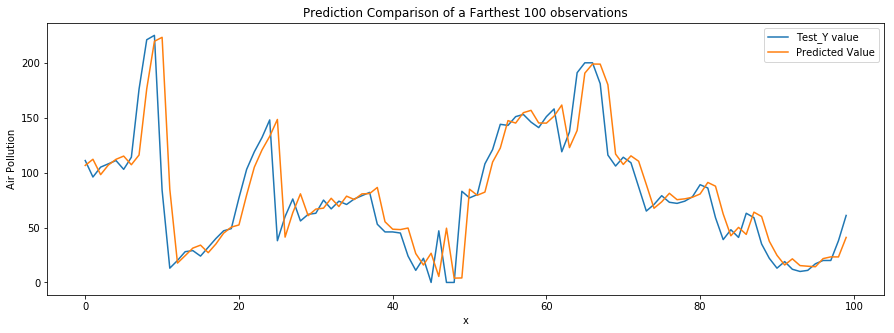

In [40]:
plot_comparison([inv_y_lstm[4000:4100], inv_yhat_lstm[4000:4100]], 
                ['Test_Y value', 'Predicted Value'], 
                title='Prediction Comparison of a Farthest 100 observations')

### Models comparison

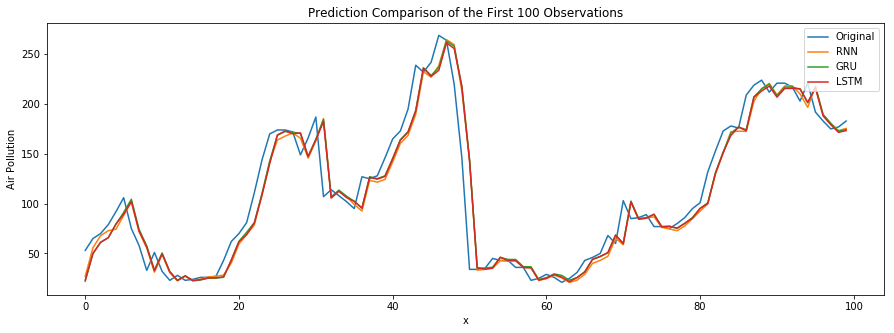

In [41]:
plot_comparison([inv_y_lstm[:100], inv_yhat_rnn[:100], 
                 inv_yhat_gru[:100], inv_yhat_lstm[:100]], 
                ['Original', 'RNN', 'GRU', 'LSTM'], 
                title='Prediction Comparison of the First 100 Observations')

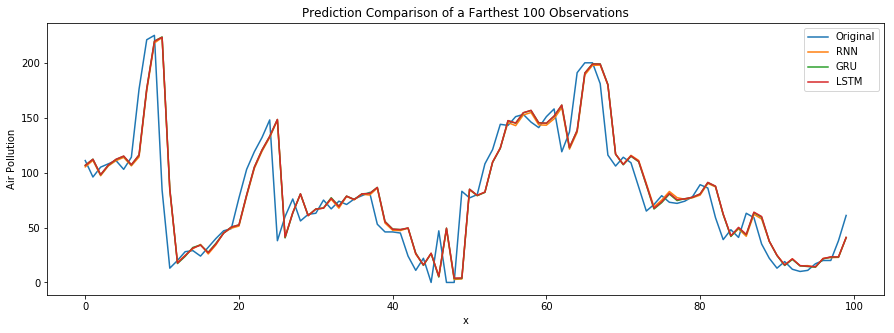

In [42]:
plot_comparison([inv_y_lstm[4000:4100], inv_yhat_rnn[4000:4100], 
                 inv_yhat_gru[4000:4100], inv_yhat_lstm[4000:4100]], 
                ['Original', 'RNN', 'GRU', 'LSTM'], 
                title='Prediction Comparison of a Farthest 100 Observations')

In [43]:
print('Comparing the RMSE of the three models:')
print('  Simple RNN: ', rmse_rnn)
print('  GRU: ', rmse_gru)
print('  LSTM: ', rmse_lstm)

Comparing the RMSE of the three models:
  Simple RNN:  24.494068
  GRU:  24.252737
  LSTM:  24.225548


# Conclusion

One can observe that all the models achieved almost the same performance. This is because the dataset used is straightforward to perform predictions and we are using only one past observation.

Would the perfomance change if we consider more past observations? See the next notebook!